In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

import random
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from keras.layers import Dense, concatenate, GlobalAveragePooling2D
import keras
from keras.models import Model
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


## Dateset Generation

In [2]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [3]:
slide_test1 = open_slide('/home/wenshen2543/slide_data/tumor_110.tif')
tumor_mask_test1 = open_slide('/home/wenshen2543/slide_data/tumor_110_mask.tif')
slide_test_image1 = read_slide(slide_test1, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide_test1.level_dimensions[5][0], 
                         height=slide_test1.level_dimensions[5][1])
tumor_mask_test_image1 = read_slide(tumor_mask_test1, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=tumor_mask_test1.level_dimensions[5][0], 
                         height=tumor_mask_test1.level_dimensions[5][1])
tumor_mask_test_image1 = tumor_mask_test_image1[:,:,0]

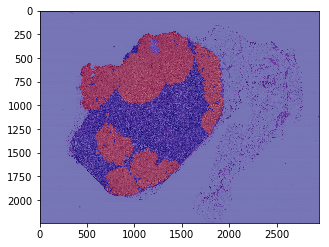

In [4]:
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_test_image1)
plt.imshow(tumor_mask_test_image1, cmap='jet', alpha=0.5)

In [5]:
slide_test2 = open_slide('/home/wenshen2543/slide_data/tumor_078.tif')
tumor_mask_test2 = open_slide('/home/wenshen2543/slide_data/tumor_078_mask.tif')
slide_test_image2 = read_slide(slide_test2, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide_test2.level_dimensions[5][0], 
                         height=slide_test2.level_dimensions[5][1])
tumor_mask_test_image2 = read_slide(tumor_mask_test2, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=tumor_mask_test2.level_dimensions[5][0], 
                         height=tumor_mask_test2.level_dimensions[5][1])
tumor_mask_test_image2 = tumor_mask_test_image2[:,:,0]

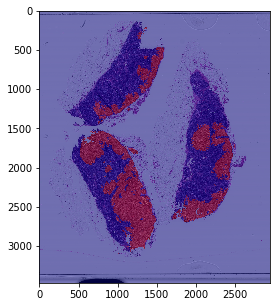

In [6]:
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_test_image2)
plt.imshow(tumor_mask_test_image2, cmap='jet', alpha=0.5)

In [7]:
slide_test3 = open_slide('/home/wenshen2543/slide_data/tumor_005.tif')
tumor_mask_test3 = open_slide('/home/wenshen2543/slide_data/tumor_005_mask.tif')
slide_test_image3 = read_slide(slide_test3, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide_test3.level_dimensions[5][0], 
                         height=slide_test3.level_dimensions[5][1])
tumor_mask_test_image3 = read_slide(tumor_mask_test3, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=tumor_mask_test3.level_dimensions[5][0], 
                         height=tumor_mask_test3.level_dimensions[5][1])
tumor_mask_test_image3 = tumor_mask_test_image3[:,:,0]

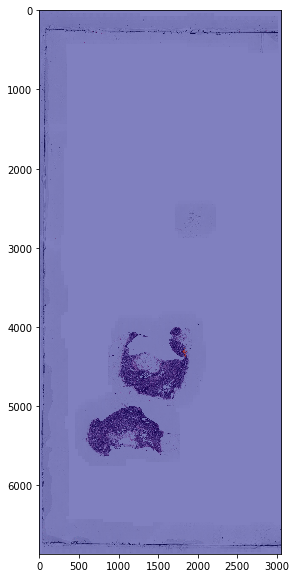

In [8]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_test_image3)
plt.imshow(tumor_mask_test_image3, cmap='jet', alpha=0.5)

In [9]:
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])


def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [10]:
def get_center_and_labels(slide_image_base, mask_image_base, downsample_factor, level):
    step = 60
    w = 60  
    labels = []
    
    width_bound = slide_image_base.level_dimensions[level][0]
    height_bound = slide_image_base.level_dimensions[level][1]
    
    center = []
  
    for j in range(0,height_bound,step):
        for i in range(0,width_bound,step):
            region = read_slide(mask_image_base, x= i * downsample_factor, y= j * downsample_factor, level= level, width=w, height=w)[:,:,0] 
            interest_region = read_slide(slide_image_base, x= i * downsample_factor, y= j * downsample_factor, level= level, width=w, height=w)
      
            tissue_pixels = find_tissue_pixels(interest_region)
            percent_tissue = len(list(tissue_pixels)) / float(interest_region.shape[0] * interest_region.shape[0])
            if percent_tissue > 0.1:
                center.append((int(i + w/2), int(j + w/2)))
                label = 1 if region.sum()>0 else 0
                labels.append(label)
    return center, labels

In [11]:
def get_center_and_labels_for_test(slide_image_base, mask_image_base, downsample_factor, level):
    step = 60
    w = 60  
    labels = []
  
    width_bound = slide_image_base.level_dimensions[level][0]
    height_bound = slide_image_base.level_dimensions[level][1]
  
    center = []
  
    for j in range(0,height_bound,step):
        for i in range(0,width_bound,step):
            region = read_slide(mask_image_base, x= i * downsample_factor, y= j * downsample_factor, level= level, width=w, height=w)[:,:,0] 
            interest_region = read_slide(slide_image_base, x= i * downsample_factor, y= j * downsample_factor, level= level, width=w, height=w)
      
            center.append((int(i + w/2), int(j + w/2)))
            
            label = 1 if region.sum()>0 else 0
            labels.append(label)
    return center, labels

In [12]:
def get_basepatches(center, slide_image_base, base_level, base_downsample_factor):
    w = 100
    base_patches = []
    
    for (i,j) in center:
        topleft_basei = int(i-w/2)
        topleft_basej = int(j-w/2)
    
   
        region_base = np.array(read_slide(slide_image_base, x= topleft_basei * base_downsample_factor, y= topleft_basej * base_downsample_factor, level= base_level, width=w, height=w))
    
    
        if topleft_basei < 0:
            region_base[:,0:(-topleft_basei),:] = 255
    
        if topleft_basei + w > slide_image_base.level_dimensions[base_level][0]:
            region_base[:,-(topleft_basei + w - slide_image_base.level_dimensions[base_level][0]):,:] =255
    
        if topleft_basej < 0:
            region_base[0:(-topleft_basej),:,:] = 255
     
        if topleft_basej + w > slide_image_base.level_dimensions[base_level][1]:
            region_base[-(topleft_basej + w - slide_image_base.level_dimensions[base_level][1]):,:,:] = 255
            
    
        base_patches.append(region_base)
    
    return base_patches

In [13]:
def get_patches(center, slide_image_base, base_level, downsample_factor, level):
    w = 100
    patches = []
  
    for (i,j) in center:
        new_i = i * 1.0 / slide_image_base.level_dimensions[base_level][0] * slide_image_base.level_dimensions[level][0]
        new_j = j * 1.0 / slide_image_base.level_dimensions[base_level][1] * slide_image_base.level_dimensions[level][1]
    
        topleft_i = int(new_i - w/2)
        topleft_j = int(new_j - w/2)
    
    
        region = np.array(read_slide(slide_image_base, x= topleft_i * downsample_factor, y= topleft_j * downsample_factor, level= level, width=w, height=w))
    
        if topleft_i < 0:
            region[:,0:(-topleft_i),:] = 255
    
        if topleft_i + w > slide_image_base.level_dimensions[level][0]:
            region[:,-(topleft_i + w - slide_image_base.level_dimensions[level][0]):,:] = 255
    
        if topleft_j < 0:
            region[0:(-topleft_j),:,:] = 255
     
        if topleft_j + w > slide_image_base.level_dimensions[level][1]:
            region[-(topleft_j + w - slide_image_base.level_dimensions[level][1]):,:,:] = 255
        
        patches.append(region)
    return patches

In [14]:
x_train1 = []
x_train2 = []

y_train = []

for i in ["091","084","101","001","016","019","023","031","057","064","081","075","096"]:
    slide_path = "/home/wenshen2543/slide_data/" + "tumor_"+ i + ".tif"
    tumor_mask_path = "/home/wenshen2543/slide_data/" + "tumor_"+ i + "_mask.tif"

    slide = open_slide(slide_path)
    tumor_mask = open_slide(tumor_mask_path)
  
    center,labels = get_center_and_labels(slide_image_base=slide, mask_image_base=tumor_mask, downsample_factor=8, level=3)
    
    base_patches = get_basepatches(center, slide_image_base=slide, base_level=3, base_downsample_factor=8)
    print("=> base_patches for Slide", i, "done successfully!")
    patches1 = get_patches(center, slide_image_base=slide, base_level=3, downsample_factor=16, level=4)
    print("=> patches1 for Slide", i, "done successfully!")
  
    x_train1 += base_patches
  
    x_train2 += patches1
  
    y_train += labels
  
    print("Get patches on Slide", i, "successfully!")

=> base_patches for Slide 091 done successfully!
=> patches1 for Slide 091 done successfully!
Get patches on Slide 091 successfully!
=> base_patches for Slide 084 done successfully!
=> patches1 for Slide 084 done successfully!
Get patches on Slide 084 successfully!
=> base_patches for Slide 101 done successfully!
=> patches1 for Slide 101 done successfully!
Get patches on Slide 101 successfully!
=> base_patches for Slide 001 done successfully!
=> patches1 for Slide 001 done successfully!
Get patches on Slide 001 successfully!
=> base_patches for Slide 016 done successfully!
=> patches1 for Slide 016 done successfully!
Get patches on Slide 016 successfully!
=> base_patches for Slide 019 done successfully!
=> patches1 for Slide 019 done successfully!
Get patches on Slide 019 successfully!
=> base_patches for Slide 023 done successfully!
=> patches1 for Slide 023 done successfully!
Get patches on Slide 023 successfully!
=> base_patches for Slide 031 done successfully!
=> patches1 for Slid

In [15]:
print(len(x_train1),len(x_train2),len(y_train))

116121 116121 116121


In [16]:
x_test1 = []
x_test2 = []
y_test = []

for i in ["078","110","005"]:
    slide_path = "/home/wenshen2543/slide_data/"+"tumor_"+ i + ".tif"
    tumor_mask_path = "/home/wenshen2543/slide_data/"+"tumor_"+ i + "_mask.tif"

    slide = open_slide(slide_path)
    tumor_mask = open_slide(tumor_mask_path)
  
    center,labels = get_center_and_labels_for_test(slide_image_base=slide, mask_image_base=tumor_mask, downsample_factor=8, level=3)
    base_patches = get_basepatches(center, slide_image_base=slide, base_level=3, base_downsample_factor=8)
    print("=> base_patches for Slide", i, "done successfully!")
    patches1 = get_patches(center, slide_image_base=slide, base_level=3, downsample_factor=16, level=4)
    print("=> patches1 for Slide", i, "done successfully!")
  
    x_test1 += base_patches
    x_test2 += patches1
  
    y_test += labels
  
    print("Get patches on Slide", i, "successfully!")

=> base_patches for Slide 078 done successfully!
=> patches1 for Slide 078 done successfully!
Get patches on Slide 078 successfully!
=> base_patches for Slide 110 done successfully!
=> patches1 for Slide 110 done successfully!
Get patches on Slide 110 successfully!
=> base_patches for Slide 005 done successfully!
=> patches1 for Slide 005 done successfully!
Get patches on Slide 005 successfully!


In [17]:
print(len(x_test1),len(x_test2),len(y_test))

168686 168686 168686


## Dataset Balancing

In [18]:
import random
def oversampling(x_train1, x_train2, y_train):
    sample_num = int(len(y_train) - sum(y_train))
    
    indices = [i for i, x in enumerate(y_train) if x == 1]
    more = [i for i, x in enumerate(y_train) if x == 0]
    
    oversample = [random.choice(indices) for _ in range(sample_num)]
    
    X1 = []
    X2 = []
    y = []
    for i in oversample:
        X1.append(x_train1[i])
        X2.append(x_train2[i])
        y.append(y_train[i])
    for i in more:
        X1.append(x_train1[i])
        X2.append(x_train2[i])
        y.append(y_train[i])
    
    X1, X2, y = shuffle(X1, X2, y, random_state=42)
    print('The final label 1 (tumor) percent to check if dataset is balance: {}%'.format(sum(y)*1.0*100/len(y)))
  
    return X1, X2, y

In [19]:
def undersampling(x_train1, x_train2, y_train):
    sample_num = int(sum(y_train))
    
    indices = [i for i, x in enumerate(y_train) if x == 0]
    more = [i for i, x in enumerate(y_train) if x == 1]
    
    oversample = [random.choice(indices) for _ in range(sample_num)]
    
    X1 = []
    X2 = []
    y = []
    for i in oversample:
        X1.append(x_train1[i])
        X2.append(x_train2[i])
        y.append(y_train[i])
    for i in more:
        X1.append(x_train1[i])
        X2.append(x_train2[i])
        y.append(y_train[i])
    
    X1, X2, y = shuffle(X1, X2, y, random_state=42)
    print('The final label 1 (tumor) percent to check if dataset is balance: {}%'.format(sum(y)*1.0*100/len(y)))
  
    return X1, X2, y

In [20]:
X_train1_over, X_train2_over, y_train_over = oversampling(x_train1, x_train2, y_train)

The final label 1 (tumor) percent to check if dataset is balance: 50.0%


In [21]:
print(len(X_train1_over),len(X_train2_over),len(y_train_over))

222134 222134 222134


In [22]:
X_train1_under, X_train2_under, y_train_under = undersampling(x_train1, x_train2, y_train)

The final label 1 (tumor) percent to check if dataset is balance: 50.0%


In [23]:
print(len(X_train1_under),len(X_train2_under),len(y_train_under))

10108 10108 10108


## Model Training
## Part1 VGG Tower
### Multi-scale Model with VGG16 Towers

### 1. Using dataset from oversampling (No data augmentation applied)

In [71]:
def My_FusionModel(X_train1, X_train2, y_train, X_test1, X_test2, y_test):
    model1 = VGG16(include_top=False, weights='imagenet',input_shape=(100, 100, 3))
    for layer in model1.layers:
        layer.trainable = False
    
    inp = model1.input
    out = model1.output

    model2 = VGG16(include_top=False, weights='imagenet',input_shape=(100, 100, 3))
    for layer in model2.layers:
        layer.name = layer.name + str("_2")
        layer.trainable = False

    inp2 = model2.input
    out2 = model2.output

    merged = concatenate([out, out2])
  
    merged = GlobalAveragePooling2D()(merged)

    merged = Dense(1024, activation='relu')(merged)
    merged = Dense(1, activation='sigmoid')(merged)

    model_fusion = Model([inp, inp2], merged)
  
    model_fusion.compile(loss='binary_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.00001),
              metrics=['acc'])
  
    model_fusion.summary()
  
    history2 = model_fusion.fit([X_train1, X_train2], y_train, epochs=10, batch_size=32, validation_split=0.1)
  
    scores = model_fusion.evaluate([X_test1, X_test2], y_test)
  
    y_predict = model_fusion.predict([X_test1, X_test2])
    y_predict_prob = y_predict
  
    y_predict_label = np.array([0]*len(y_test))
    y_predict_label[(np.where(y_predict_prob>=0.5)[0])] = 1

  
    print(y_predict_label.shape)
    print('Loss (Two-scale Model):', scores[0])
    print('Accuracy (Two-scale Model):', scores[1])
    print('Precision (Two-scale Model):', precision_score(y_test,y_predict_label))
    print('Recall (Two-scale Model):', recall_score(y_test,y_predict_label))
    print('F1 (Two-scale Model):', f1_score(y_test,y_predict_label))
    print('ROCAUC (Two-scale Model):', roc_auc_score(y_test,y_predict_label))
    print('Confusion Matrix (Two-scale Model):\n', confusion_matrix(y_test,y_predict_label))
  
    return model_fusion, y_predict_label, y_predict_prob, history2

In [72]:
model_vgg2, y_predict_label_vgg2, y_predict_prob_vgg2, history2 = My_FusionModel(np.asarray(X_train1_over), np.asarray(X_train2_over), np.asarray(y_train_over),np.asarray(x_test1),np.asarray(x_test2),np.asarray(y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
input_10_2 (InputLayer)         (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 100, 100, 64) 1792        input_9[0][0]                    
__________________________________________________________________________________________________
block1_conv1_2 (Conv2D)         (None, 100, 100, 64) 1792        input_10_2[0][0]                 
__________________________________________________________________________________________________
block1_con

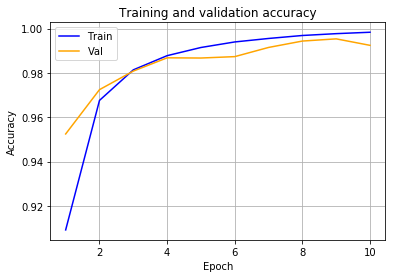

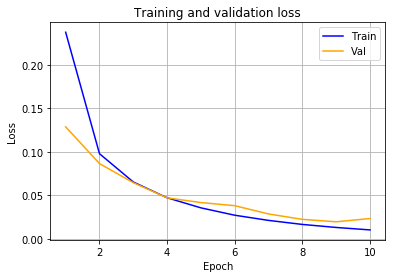

In [73]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Get the number of epochs
epochs = range(1,len(acc)+1)

plt.title('Training and validation accuracy')
plt.grid()
plt.plot(epochs, acc, color='blue', label='Train')
plt.plot(epochs, val_acc, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Training and validation loss')
plt.grid()
plt.plot(epochs, loss, color='blue', label='Train')
plt.plot(epochs, val_loss, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [74]:
len(y_predict_prob_vgg2)
#078: 45704 => [0:45704]
#110: 29550 => [45704:75254]
#005: 93432 => [75254:168686]

168686

In [75]:
slide_path = "/home/wenshen2543/slide_data/tumor_078.tif"
tumor_mask_path = "/home/wenshen2543/slide_data/tumor_078_mask.tif"

slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
slide_path = "/home/wenshen2543/slide_data/tumor_110.tif"
tumor_mask_path = "/home/wenshen2543/slide_data/tumor_110_mask.tif"

slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))

slide_path = "/home/wenshen2543/slide_data/tumor_005.tif"
tumor_mask_path = "/home/wenshen2543/slide_data/tumor_005_mask.tif"

slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))

Read WSI from /home/wenshen2543/slide_data/tumor_078.tif with width: 94208, height: 111104
Read tumor mask from /home/wenshen2543/slide_data/tumor_078_mask.tif
Slide includes %d levels 9
Level 0, dimensions: (94208, 111104) downsample factor 1
Level 1, dimensions: (47104, 55552) downsample factor 2
Level 2, dimensions: (23552, 27776) downsample factor 4
Level 3, dimensions: (11776, 13888) downsample factor 8
Level 4, dimensions: (5888, 6944) downsample factor 16
Level 5, dimensions: (2944, 3472) downsample factor 32
Level 6, dimensions: (1472, 1736) downsample factor 64
Level 7, dimensions: (736, 868) downsample factor 128
Level 8, dimensions: (368, 434) downsample factor 256
Read WSI from /home/wenshen2543/slide_data/tumor_110.tif with width: 94208, height: 71680
Read tumor mask from /home/wenshen2543/slide_data/tumor_110_mask.tif
Slide includes %d levels 9
Level 0, dimensions: (94208, 71680) downsample factor 1
Level 1, dimensions: (47104, 35840) downsample factor 2
Level 2, dimensio

In [76]:
# 078: 11776//60 + 1 = 197 ===> (197, 232)
# 110: 11776//60 + 1 = 197 ===> (197, 150)
# 005: 12224//60 + 1 = 204 ===> (204, 458)

In [77]:
#from PIL import Image
from PIL import Image
# 110 slide
test1 = Image.fromarray(slide_test_image1.astype('uint8'), 'RGB')
test1 = test1.resize((197,150), Image.ANTIALIAS)

# 078 slide
test2 = Image.fromarray(slide_test_image2.astype('uint8'), 'RGB')
test2 = test2.resize((197,232), Image.ANTIALIAS)

# 005 slide
test3 = Image.fromarray(slide_test_image3.astype('uint8'), 'RGB')
test3 = test3.resize((204,458), Image.ANTIALIAS)


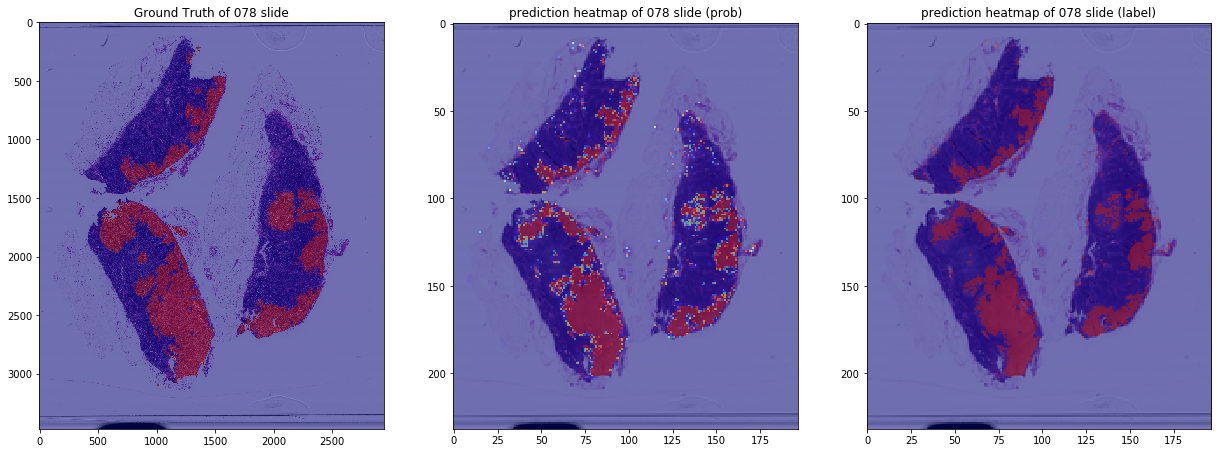

In [78]:
# Ground Truth of 078 slide
plt.figure(figsize=(21,21), dpi=100)
plt.subplot(1,3,1)
plt.title("Ground Truth of 078 slide")
plt.imshow(slide_test_image2)
plt.imshow(tumor_mask_test_image2, cmap='jet', alpha=0.5)

# prediction of probability heatmap of 078 slide
plt.subplot(1,3,2)
plt.title("prediction heatmap of 078 slide (prob)")
prob_image2 = np.reshape(y_predict_prob_vgg2[0:45704],(-1,197))
plt.imshow(test2)
plt.imshow(prob_image2 , cmap='jet',alpha=0.5)

# prediction of label heatmap of 078 slide
plt.subplot(1,3,3)
plt.title("prediction heatmap of 078 slide (label)")
label_image2 = np.reshape(y_predict_label_vgg2[0:45704],(-1,197))
plt.imshow(test2)
plt.imshow(label_image2 , cmap='jet',alpha=0.5)

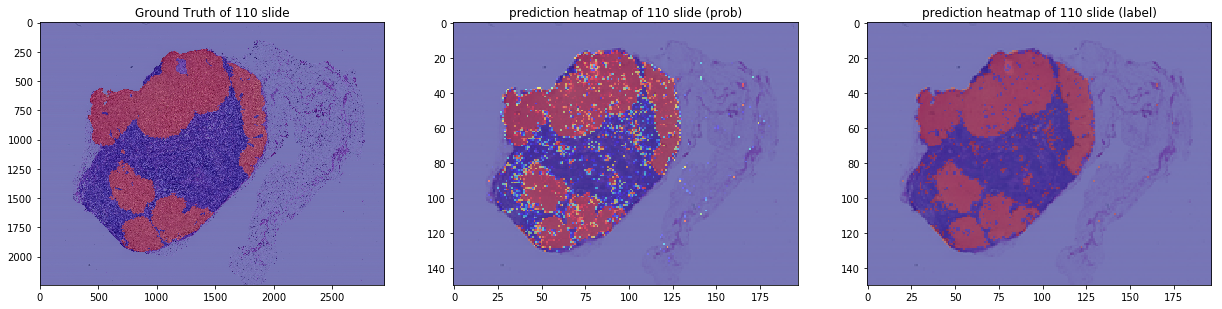

In [79]:
# Ground Truth of 110 slide
plt.figure(figsize=(21,21), dpi=100)
plt.subplot(1,3,1)
plt.title("Ground Truth of 110 slide")
plt.imshow(slide_test_image1)
plt.imshow(tumor_mask_test_image1, cmap='jet', alpha=0.5)

# prediction of probability heatmap of 110 slide
plt.subplot(1,3,2)
plt.title("prediction heatmap of 110 slide (prob)")
prob_image1 = np.reshape(y_predict_prob_vgg2[45704:75254],(-1,197))
plt.imshow(test1)
plt.imshow(prob_image1 , cmap='jet',alpha=0.5)

# prediction of label heatmap of 110 slide
plt.subplot(1,3,3)
plt.title("prediction heatmap of 110 slide (label)")
label_image1 = np.reshape(y_predict_label_vgg2[45704:75254],(-1,197))
plt.imshow(test1)
plt.imshow(label_image1 , cmap='jet',alpha=0.5)

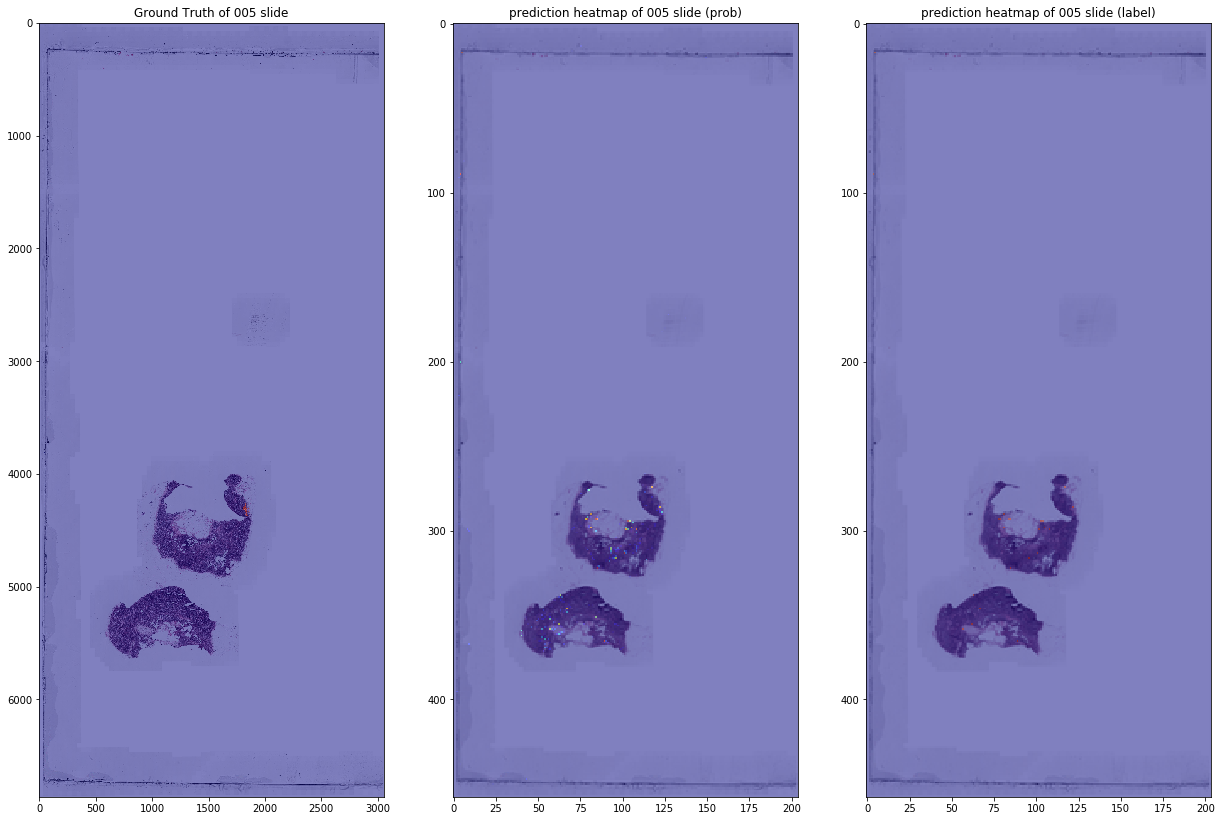

In [80]:
# Ground Truth of 005 slide
plt.figure(figsize=(21,21), dpi=100)
plt.subplot(1,3,1)
plt.title("Ground Truth of 005 slide")
plt.imshow(slide_test_image3)
plt.imshow(tumor_mask_test_image3, cmap='jet', alpha=0.5)

# prediction of probability heatmap of 005 slide
plt.subplot(1,3,2)
plt.title("prediction heatmap of 005 slide (prob)")
prob_image3 = np.reshape(y_predict_prob_vgg2[75254:],(-1,204))
plt.imshow(test3)
plt.imshow(prob_image3 , cmap='jet',alpha=0.5)

# prediction of label heatmap of 005 slide
plt.subplot(1,3,3)
plt.title("prediction heatmap of 005 slide (label)")
label_image3 = np.reshape(y_predict_label_vgg2[75254:],(-1,204))
plt.imshow(test3)
plt.imshow(label_image3 , cmap='jet',alpha=0.5)

In [81]:
model_vgg2.save_weights('/home/wenshen2543/model/model_vgg2_weights.h5')
model_vgg2.save('/home/wenshen2543/model/model_vgg2.h5')

/home/wenshen2543/anaconda3/lib/python3.5/site-packages/keras/engine/saving.py:118: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


### 2. Using dataset from undersampling (Data augmentation applied)

In [30]:
from sklearn.model_selection import train_test_split
X_train1, X_val1, X_train2, X_val2, Y_train, Y_val = train_test_split(X_train1_under, X_train2_under, y_train_under, test_size=0.33, random_state=42, shuffle=True)

In [24]:
from keras.preprocessing.image import ImageDataGenerator

In [25]:
generator = ImageDataGenerator(rotation_range=90, width_shift_range=0.05, height_shift_range=0.05,zoom_range=0.1)

def generate_data_generator_for_two_images(X1, X2, Y):
    genX1 = generator.flow(X1, Y, seed=7)
    genX2 = generator.flow(X2, seed=7)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i], X1i[1]

In [48]:
image_gen_train_fusion = generate_data_generator_for_two_images(np.asarray(X_train1), np.asarray(X_train2), np.asarray(Y_train))

In [49]:
generator = ImageDataGenerator()
image_gen_val_fusion = generate_data_generator_for_two_images(np.asarray(X_val1), np.asarray(X_val2), np.asarray(Y_val))

In [50]:
def My_FusionModel2(train_data_gen, val_data_gen, y_train, y_val, X_test1, X_test2, y_test):
    model1 = VGG16(include_top=False, weights='imagenet',input_shape=(100, 100, 3))
    for layer in model1.layers:
        layer.trainable = False
    
    inp = model1.input
    out = model1.output

    model2 = VGG16(include_top=False, weights='imagenet',input_shape=(100, 100, 3))
    for layer in model2.layers:
        layer.name = layer.name + str("_2")
        layer.trainable = False

    inp2 = model2.input
    out2 = model2.output
    
    merged = concatenate([out, out2])
  
    merged = GlobalAveragePooling2D()(merged)

    merged = Dense(1024, activation='relu')(merged)
    merged = Dense(1, activation='sigmoid')(merged)

    model_fusion = Model([inp, inp2], merged)
  
    model_fusion.compile(loss='binary_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.00001),
              metrics=['acc'])
  
    model_fusion.summary()
  
    history3 = model_fusion.fit_generator(train_data_gen,steps_per_epoch=int(np.ceil(len(y_train) / float(64))), epochs=10, validation_data=val_data_gen, validation_steps=int(np.ceil(len(y_val) / float(64))))
    
    scores = model_fusion.evaluate([X_test1, X_test2], y_test)
  
    y_predict = model_fusion.predict([X_test1, X_test2])
    y_predict_prob = y_predict
  
    y_predict_label = np.array([0]*len(y_test))
    y_predict_label[(np.where(y_predict_prob>=0.5)[0])] = 1

  
    print(y_predict_label.shape)
    print('Loss (Two-scale Model):', scores[0])
    print('Accuracy (Two-scale Model):', scores[1])
    print('Precision (Two-scale Model):', precision_score(y_test,y_predict_label))
    print('Recall (Two-scale Model):', recall_score(y_test,y_predict_label))
    print('F1 (Two-scale Model):', f1_score(y_test,y_predict_label))
    print('ROCAUC (Two-scale Model):', roc_auc_score(y_test,y_predict_label))
    print('Confusion Matrix (Two-scale Model):\n', confusion_matrix(y_test,y_predict_label))
  
    return model_fusion, y_predict_label, y_predict_prob, history3

In [51]:
model_vgg3, y_predict_label_vgg3, y_predict_prob_vgg3, history3 = My_FusionModel2(image_gen_train_fusion, image_gen_val_fusion, np.asarray(Y_train), np.asarray(Y_val), np.asarray(x_test1),np.asarray(x_test2),np.asarray(y_test))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
input_8_2 (InputLayer)          (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 100, 100, 64) 1792        input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_2 (Conv2D)         (None, 100, 100, 64) 1792        input_8_2[0][0]                  
__________________________________________________________________________________________________
block1_con

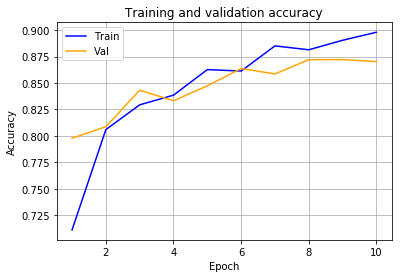

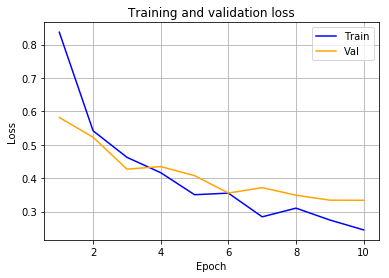

In [64]:
acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

# Get the number of epochs
epochs = range(1,len(acc)+1)

plt.title('Training and validation accuracy')
plt.grid()
plt.plot(epochs, acc, color='blue', label='Train')
plt.plot(epochs, val_acc, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Training and validation loss')
plt.grid()
plt.plot(epochs, loss, color='blue', label='Train')
plt.plot(epochs, val_loss, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [52]:
#from PIL import Image
from PIL import Image
# 110 slide
test1 = Image.fromarray(slide_test_image1.astype('uint8'), 'RGB')
test1 = test1.resize((197,150), Image.ANTIALIAS)

# 078 slide
test2 = Image.fromarray(slide_test_image2.astype('uint8'), 'RGB')
test2 = test2.resize((197,232), Image.ANTIALIAS)

# 005 slide
test3 = Image.fromarray(slide_test_image3.astype('uint8'), 'RGB')
test3 = test3.resize((204,458), Image.ANTIALIAS)


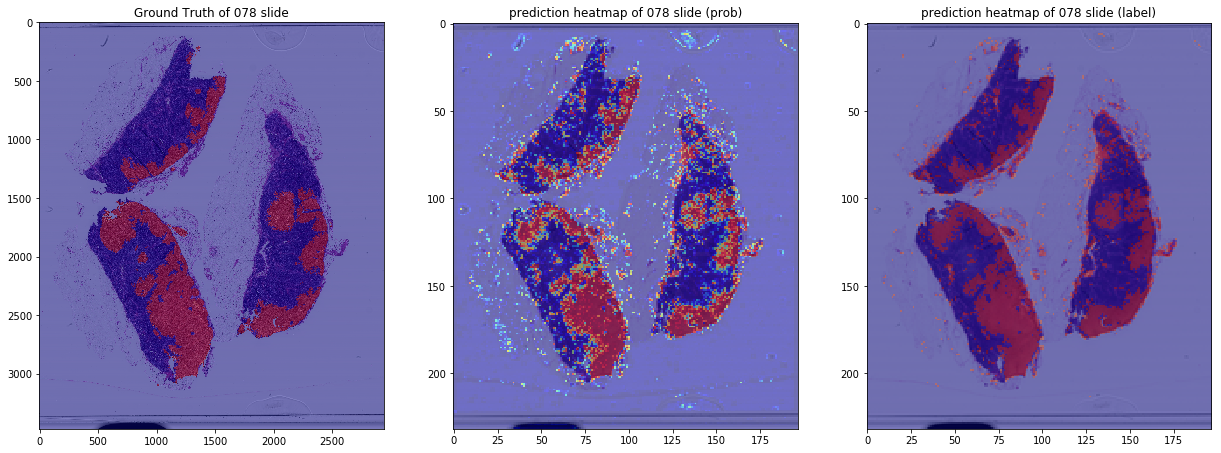

In [54]:
# Ground Truth of 078 slide
plt.figure(figsize=(21,21), dpi=100)
plt.subplot(1,3,1)
plt.title("Ground Truth of 078 slide")
plt.imshow(slide_test_image2)
plt.imshow(tumor_mask_test_image2, cmap='jet', alpha=0.5)

# prediction of probability heatmap of 078 slide
plt.subplot(1,3,2)
plt.title("prediction heatmap of 078 slide (prob)")
prob_image2 = np.reshape(y_predict_prob_vgg3[0:45704],(-1,197))
plt.imshow(test2)
plt.imshow(prob_image2 , cmap='jet',alpha=0.5)

# prediction of label heatmap of 078 slide
plt.subplot(1,3,3)
plt.title("prediction heatmap of 078 slide (label)")
label_image2 = np.reshape(y_predict_label_vgg3[0:45704],(-1,197))
plt.imshow(test2)
plt.imshow(label_image2 , cmap='jet',alpha=0.5)

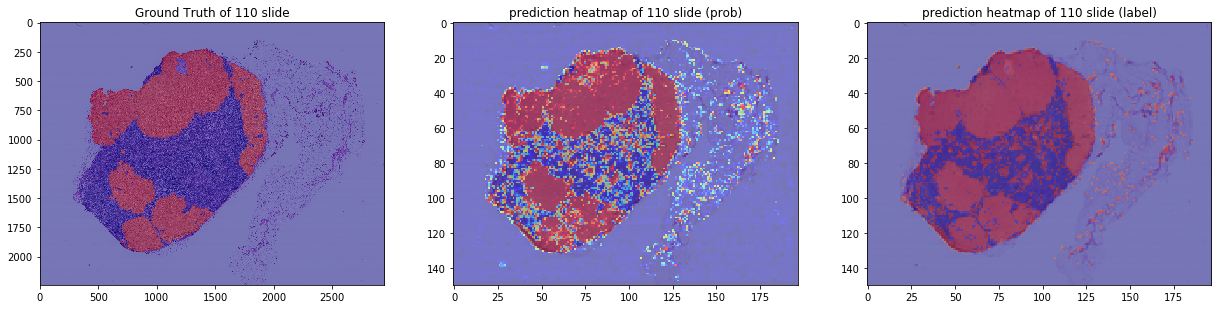

In [55]:
# Ground Truth of 110 slide
plt.figure(figsize=(21,21), dpi=100)
plt.subplot(1,3,1)
plt.title("Ground Truth of 110 slide")
plt.imshow(slide_test_image1)
plt.imshow(tumor_mask_test_image1, cmap='jet', alpha=0.5)

# prediction of probability heatmap of 110 slide
plt.subplot(1,3,2)
plt.title("prediction heatmap of 110 slide (prob)")
prob_image1 = np.reshape(y_predict_prob_vgg3[45704:75254],(-1,197))
plt.imshow(test1)
plt.imshow(prob_image1 , cmap='jet',alpha=0.5)

# prediction of label heatmap of 110 slide
plt.subplot(1,3,3)
plt.title("prediction heatmap of 110 slide (label)")
label_image1 = np.reshape(y_predict_label_vgg3[45704:75254],(-1,197))
plt.imshow(test1)
plt.imshow(label_image1 , cmap='jet',alpha=0.5)

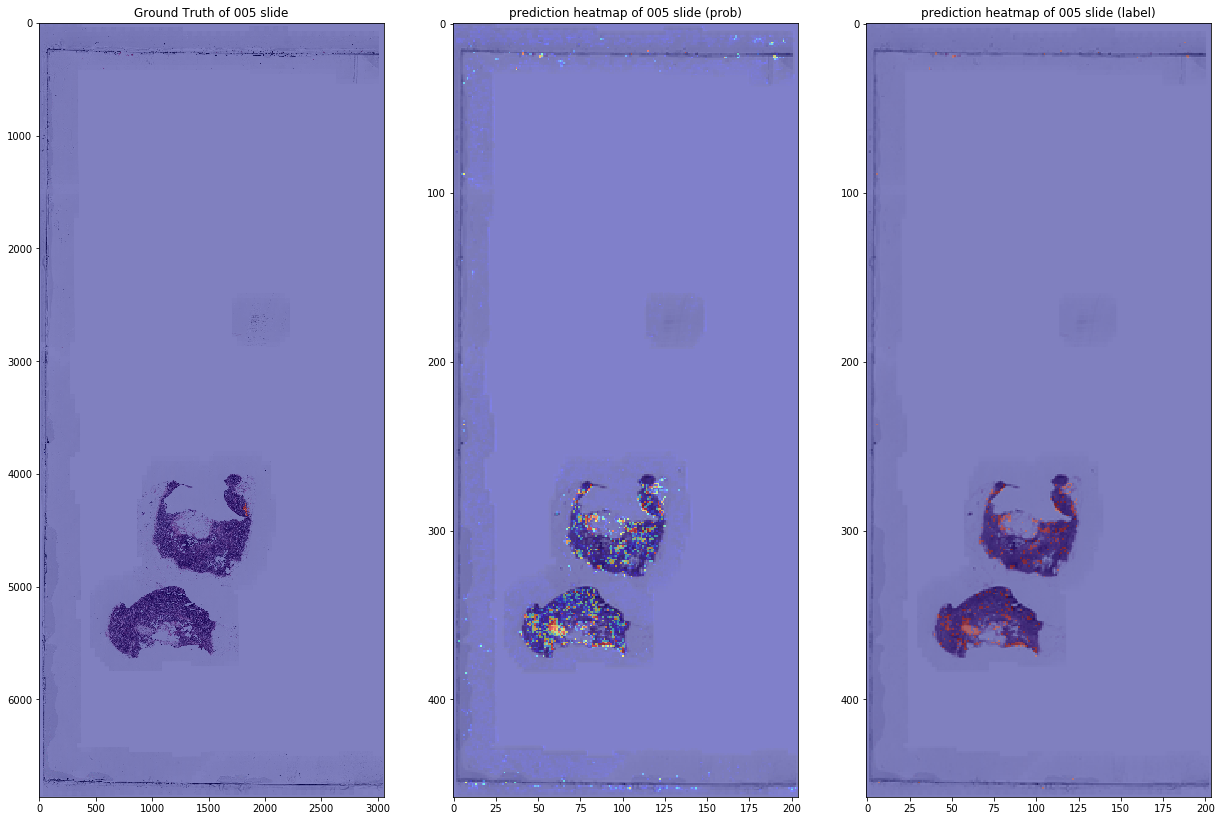

In [56]:
# Ground Truth of 005 slide
plt.figure(figsize=(21,21), dpi=100)
plt.subplot(1,3,1)
plt.title("Ground Truth of 005 slide")
plt.imshow(slide_test_image3)
plt.imshow(tumor_mask_test_image3, cmap='jet', alpha=0.5)

# prediction of probability heatmap of 005 slide
plt.subplot(1,3,2)
plt.title("prediction heatmap of 005 slide (prob)")
prob_image3 = np.reshape(y_predict_prob_vgg3[75254:],(-1,204))
plt.imshow(test3)
plt.imshow(prob_image3 , cmap='jet',alpha=0.5)

# prediction of label heatmap of 005 slide
plt.subplot(1,3,3)
plt.title("prediction heatmap of 005 slide (label)")
label_image3 = np.reshape(y_predict_label_vgg3[75254:],(-1,204))
plt.imshow(test3)
plt.imshow(label_image3 , cmap='jet',alpha=0.5)

In [57]:
model_vgg3.save_weights('/home/wenshen2543/model/model_vgg3_weights.h5')
model_vgg3.save('/home/wenshen2543/model/model_vgg3.h5')

/home/wenshen2543/anaconda3/lib/python3.5/site-packages/keras/engine/saving.py:118: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


### Single-scale Model with VGG16 Tower

In [60]:
def My_SingleModel(X_train, y_train, X_test, y_test):
    base_vgg = tf.keras.applications.VGG16(weights='imagenet',include_top=False, input_shape=(100, 100, 3))
    base_vgg.trainable = False
    model = tf.keras.models.Sequential([
        base_vgg,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')])
  
    model.compile(loss='binary_crossentropy',
                optimizer=tf.train.AdamOptimizer(),
                metrics=['acc'])
    model.summary()
  
    history = model.fit(X_train,y_train,epochs=10,batch_size=32, validation_split=0.1)
  
    scores = model.evaluate(X_test, y_test)
  
    y_predict = model.predict(X_test)
    y_predict_prob = model.predict_proba(X_test)
    y_predict_label = model.predict_classes(X_test)
  
    print(y_predict_label.shape)
    print('Loss (Single-scale Model):', scores[0])
    print('Accuracy (Single-scale Model):', scores[1])
    print('Precision (Single-scale Model):', precision_score(y_test,y_predict_label))
    print('Recall (Single-scale Model):', recall_score(y_test,y_predict_label))
    print('F1 (Single-scale Model):', f1_score(y_test,y_predict_label))
    print('ROCAUC (Single-scale Model):', roc_auc_score(y_test,y_predict_label))
    print('Confusion Matrix (Single-scale Model):\n', confusion_matrix(y_test,y_predict_label))
  
    return model, y_predict_label, y_predict_prob, history

In [62]:
model_vgg1, y_predict_label_vgg1, y_predict_prob_vgg1, history = My_SingleModel(np.asarray(X_train1_over),np.asarray(y_train_over),np.asarray(x_test1),np.asarray(y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 14,780,481
Trainable params: 65,793
Non-trainable params: 14,714,688
_________________________________________________________________
Train on 199920 samples, validate on 22214 samples
Epoch 1/10
199920/199920 [==============================] - 551s 3ms/sample - loss: 0.1840 - acc: 0.9285 - val_loss: 0.1004 - val_acc: 0.9630
Epoch 2/10
199920/199920 [==============================] - 549s

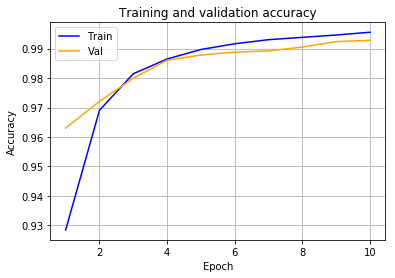

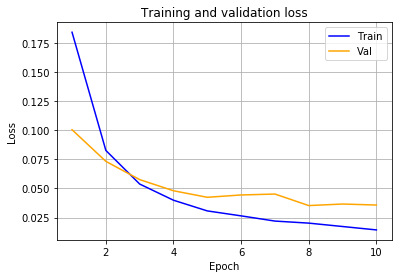

In [63]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs = range(1,len(acc)+1)

plt.title('Training and validation accuracy')
plt.grid()
plt.plot(epochs, acc, color='blue', label='Train')
plt.plot(epochs, val_acc, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Training and validation loss')
plt.grid()
plt.plot(epochs, loss, color='blue', label='Train')
plt.plot(epochs, val_loss, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

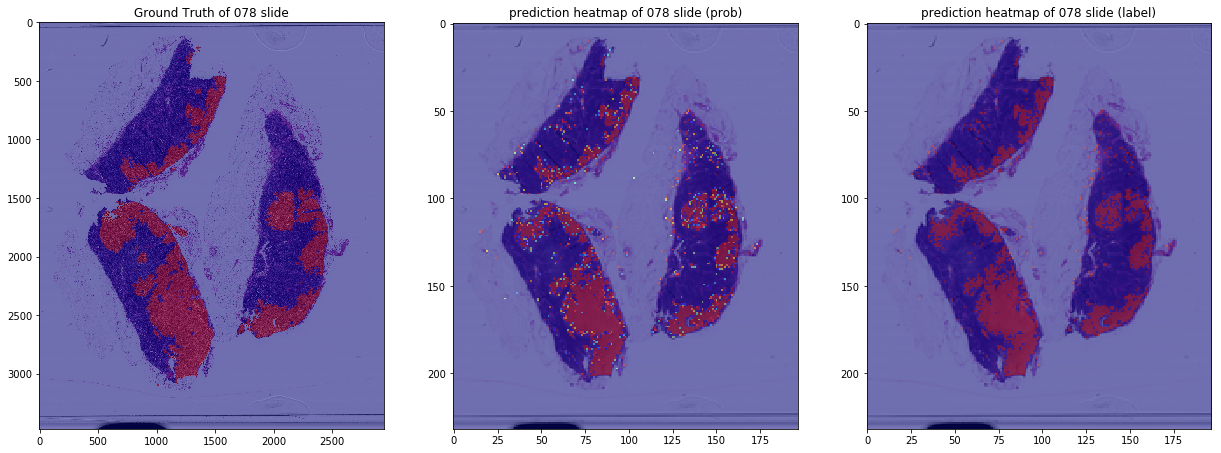

In [66]:
# Ground Truth of 078 slide
plt.figure(figsize=(21,21), dpi=100)
plt.subplot(1,3,1)
plt.title("Ground Truth of 078 slide")
plt.imshow(slide_test_image2)
plt.imshow(tumor_mask_test_image2, cmap='jet', alpha=0.5)

# prediction of probability heatmap of 078 slide
plt.subplot(1,3,2)
plt.title("prediction heatmap of 078 slide (prob)")
prob_image2 = np.reshape(y_predict_prob_vgg1[0:45704],(-1,197))
plt.imshow(test2)
plt.imshow(prob_image2 , cmap='jet',alpha=0.5)

# prediction of label heatmap of 078 slide
plt.subplot(1,3,3)
plt.title("prediction heatmap of 078 slide (label)")
label_image2 = np.reshape(y_predict_label_vgg1[0:45704],(-1,197))
plt.imshow(test2)
plt.imshow(label_image2 , cmap='jet',alpha=0.5)

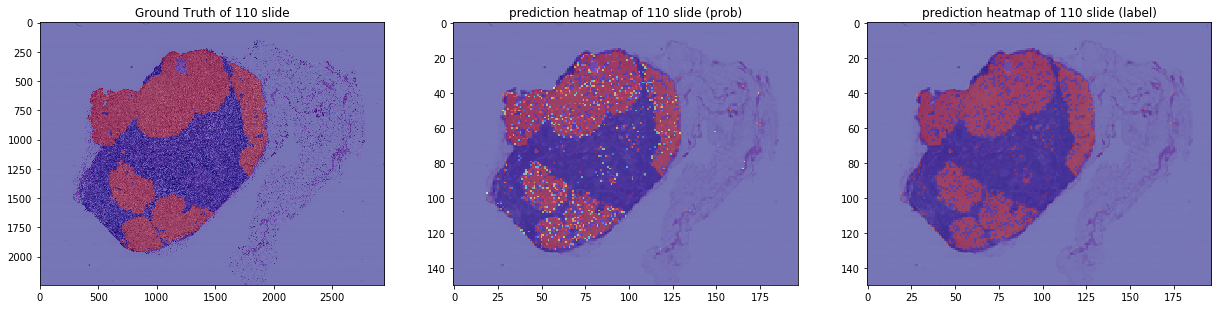

In [67]:
# Ground Truth of 110 slide
plt.figure(figsize=(21,21), dpi=100)
plt.subplot(1,3,1)
plt.title("Ground Truth of 110 slide")
plt.imshow(slide_test_image1)
plt.imshow(tumor_mask_test_image1, cmap='jet', alpha=0.5)

# prediction of probability heatmap of 110 slide
plt.subplot(1,3,2)
plt.title("prediction heatmap of 110 slide (prob)")
prob_image1 = np.reshape(y_predict_prob_vgg1[45704:75254],(-1,197))
plt.imshow(test1)
plt.imshow(prob_image1 , cmap='jet',alpha=0.5)

# prediction of label heatmap of 110 slide
plt.subplot(1,3,3)
plt.title("prediction heatmap of 110 slide (label)")
label_image1 = np.reshape(y_predict_label_vgg1[45704:75254],(-1,197))
plt.imshow(test1)
plt.imshow(label_image1 , cmap='jet',alpha=0.5)

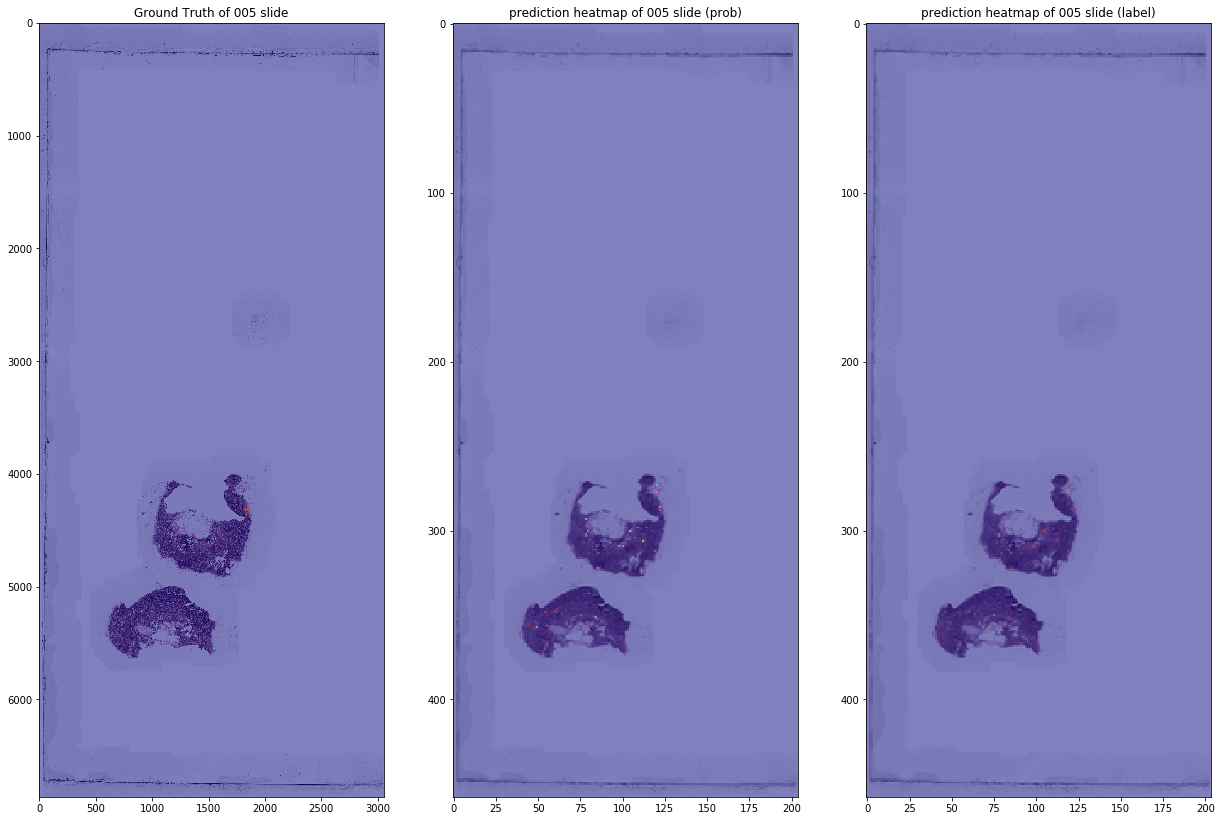

In [68]:
# Ground Truth of 005 slide
plt.figure(figsize=(21,21), dpi=100)
plt.subplot(1,3,1)
plt.title("Ground Truth of 005 slide")
plt.imshow(slide_test_image3)
plt.imshow(tumor_mask_test_image3, cmap='jet', alpha=0.5)

# prediction of probability heatmap of 005 slide
plt.subplot(1,3,2)
plt.title("prediction heatmap of 005 slide (prob)")
prob_image3 = np.reshape(y_predict_prob_vgg1[75254:],(-1,204))
plt.imshow(test3)
plt.imshow(prob_image3 , cmap='jet',alpha=0.5)

# prediction of label heatmap of 005 slide
plt.subplot(1,3,3)
plt.title("prediction heatmap of 005 slide (label)")
label_image3 = np.reshape(y_predict_label_vgg1[75254:],(-1,204))
plt.imshow(test3)
plt.imshow(label_image3, cmap='jet',alpha=0.5)

In [69]:
model_vgg1.save_weights('/home/wenshen2543/model/model_vgg1_weights.h5')
model_vgg1.save('/home/wenshen2543/model/model_vgg1.h5')

## Comparison and Summary

In [27]:
import pandas as pd
pd.DataFrame({"Evaluation Metrics": ["Loss","Accuracy","Precison","Recall","F1", "AUC","TN/TP/FN/FP"],
              "Multi-scale Model(oversampling)": [0.1098,0.978,0.923,0.704,0.799,0.850,"157466/7461/3139/620"],
              "Multi-scale Model(undersampling+data augmentation)": [0.1145,0.965,0.689,0.811,0.745,0.893,"154199/8592/2008/3007"],
              "Single-scale Model(oversampling)": [0.2452,0.974,0.944,0.617,0.746,0.807,"157701/6541/4059/385"]})

Evaluation Metrics Multi-scale Model(oversampling)  \
0               Loss                          0.1098   
1           Accuracy                           0.978   
2           Precison                           0.923   
3             Recall                           0.704   
4                 F1                           0.799   
5                AUC                            0.85   
6        TN/TP/FN/FP            157466/7461/3139/620   

  Multi-scale Model(undersampling+data augmentation)  \
0                                             0.1145   
1                                              0.965   
2                                              0.689   
3                                              0.811   
4                                              0.745   
5                                              0.893   
6                              154199/8592/2008/3007   

  Single-scale Model(oversampling)  
0                           0.2452  
1                            0.974  
2                            0.944  
3                            0.617  
4                            0.746  
5                            0.807  
6             157701/6541/4059/385

I used loss, accuracy, precision, recall, F1, AUC and confusion matrix to evaluate the performance of each model. The results are displayed above.
1. When comparing the performance of multi-scale model and single-scale model, I observed similar results as the paper that using patches from different zoom level would not effectively improve the accuracy, but it could smooth the boundaries.
2. Since the original dataset is highly imbalanced, I used two resampling approches (oversampling and undersampling) to balance dataset. Since there were fewer tumor patches, I also included data augmentation with undersampling. When using undersampling, it increased recall with the cost of precison, which means more tumor patches were recognized but the it also recognized many normal patches as tumor.
3. For the model achitecture, I used VGG16 and transfer learning as my first choice. It is because the training dataset is of large size and contains 199,920 patches. A deep model like VGG16 which consist of 13 convolutional layers may be good at extracting features from a large dataset. And the results look good when using VGG16. It achieved over 95% accuracy in both multi-scale and single-scale model.